In [45]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
#from mlxtend.plotting import plot_decision_regions

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, precision_recall_fscore_support
from sklearn.metrics import roc_curve, roc_auc_score

from imblearn.over_sampling import SMOTE
from collections import Counter

In [46]:
df = pd.read_pickle('Dataset.pkl')

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13649 entries, 0 to 13663
Data columns (total 28 columns):
 #   Column                                     Non-Null Count  Dtype          
---  ------                                     --------------  -----          
 0   UNIT_TEXT                                  13649 non-null  object         
 1   MEPP_y                                     13649 non-null  object         
 2   TOTAL_VALUE                                13649 non-null  float64        
 3   target                                     13649 non-null  int64          
 4   target_v2                                  13649 non-null  int64          
 5   TEMPO_DURACAO                              13649 non-null  timedelta64[ns]
 6   TEMPO_RECURSO                              13649 non-null  timedelta64[ns]
 7   Fechamento_DIA                             13649 non-null  float64        
 8   PRODUCAO_ACO_CRU_BRASIL_MIL_TONELADAS_MES  13649 non-null  float64        
 9   PRODUC

In [48]:
df.drop(['VARIACAO_COTACAO_MINERIO_FERRO_MES'],axis=1, inplace=True)

In [49]:
from numpy import int64

df['TEMPO_DURACAO'] = df['TEMPO_DURACAO'].astype(int64)
df['TEMPO_RECURSO'] = df['TEMPO_RECURSO'].astype(int64)

Text(0.5, 1.0, 'Valores Faltantes')

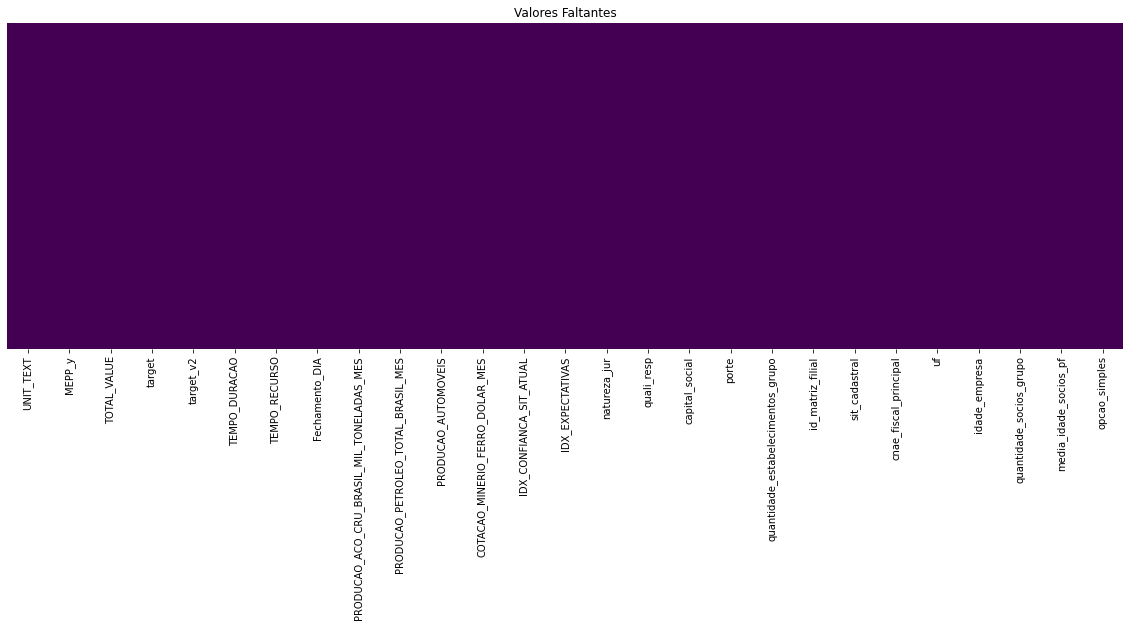

In [50]:
plt.figure(figsize=(20,6))
sns.heatmap(df.isna(),cbar=False,cmap='viridis',yticklabels=False)
plt.title('Valores Faltantes')

<AxesSubplot:>

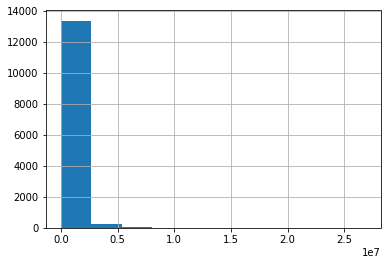

In [51]:
df['TOTAL_VALUE'].hist()

In [52]:
from sklearn.preprocessing import RobustScaler

# Create a RobustScaler object
scaler = RobustScaler()

scaled_values = scaler.fit_transform(df[['TOTAL_VALUE']])

df.drop(['TOTAL_VALUE'], axis=1, inplace=True)

df['TOTAL_VALUE_scaled'] = pd.Series(scaled_values.reshape(-1), index=df.index)

<AxesSubplot:>

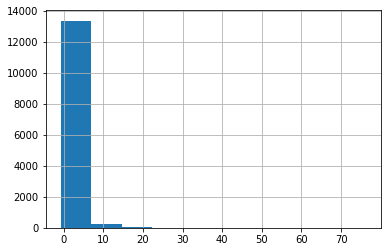

In [53]:
df['TOTAL_VALUE_scaled'].hist()

<AxesSubplot:>

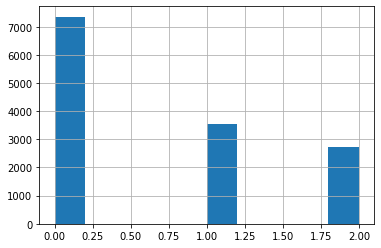

In [54]:
df['target'].hist()

In [55]:
df['target'].unique()

array([0, 2, 1], dtype=int64)

<AxesSubplot:>

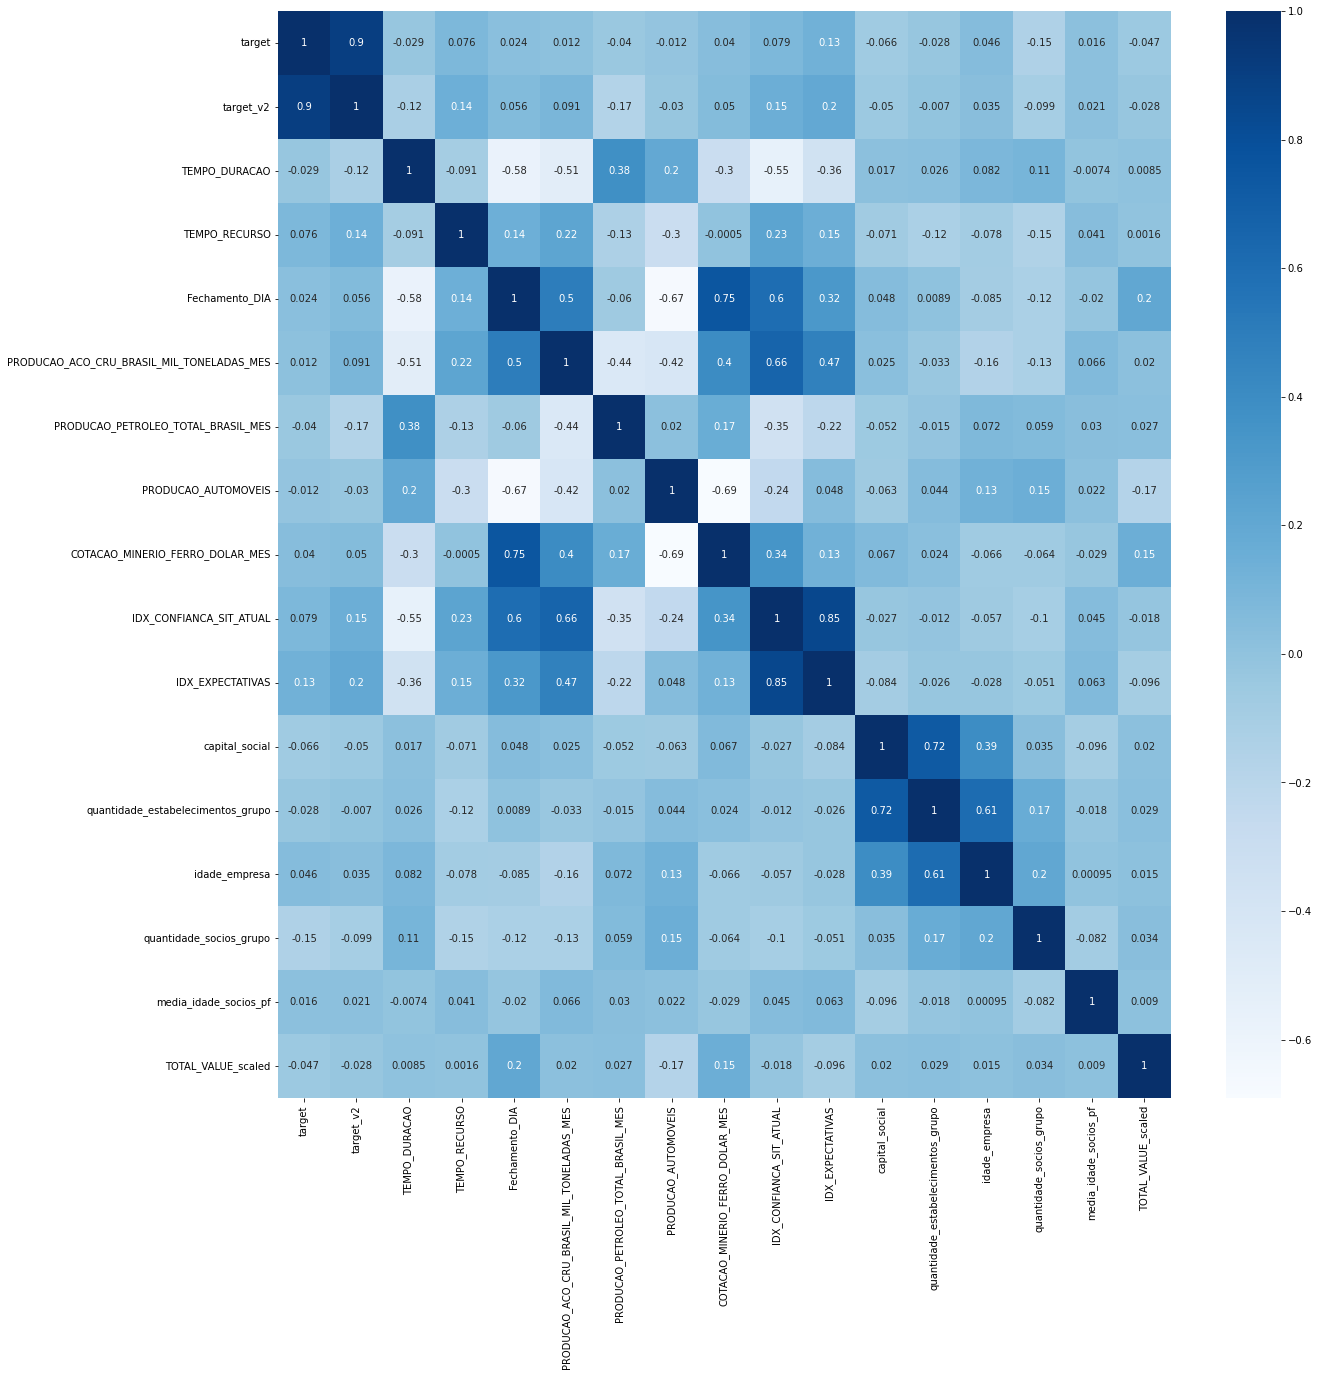

In [56]:
import matplotlib.pyplot as plt

# correlation plot
corr = df.corr()
fig, ax = plt.subplots(figsize=(20,20))         # Sample figsize in inches
sns.heatmap(corr, cmap = 'Blues', annot= True)

<AxesSubplot:>

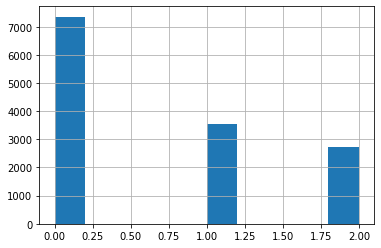

In [57]:
df.target.hist()

In [58]:
one_hot_encoding_columns = df.describe(include='O').T.reset_index()['index'].to_list()
one_hot_encoding_columns


['UNIT_TEXT',
 'MEPP_y',
 'natureza_jur',
 'quali_resp',
 'porte',
 'id_matriz_filial',
 'sit_cadastral',
 'cnae_fiscal_principal',
 'uf',
 'opcao_simples']

In [59]:
prefix = dict(zip(one_hot_encoding_columns, one_hot_encoding_columns))
prefix

{'UNIT_TEXT': 'UNIT_TEXT',
 'MEPP_y': 'MEPP_y',
 'natureza_jur': 'natureza_jur',
 'quali_resp': 'quali_resp',
 'porte': 'porte',
 'id_matriz_filial': 'id_matriz_filial',
 'sit_cadastral': 'sit_cadastral',
 'cnae_fiscal_principal': 'cnae_fiscal_principal',
 'uf': 'uf',
 'opcao_simples': 'opcao_simples'}

In [60]:
def logistic_regression_versao(in_versao, in_X_train, in_y_train, in_X_test, in_y_test, in_tune = False, in_multi= False):
    print(f'############### {in_versao} ###############')
    #Fit Logistic Regression model:
    X_train = in_X_train
    y_train = in_y_train
    
    X_test = in_X_test
    y_test = in_y_test
    logisticregression = LogisticRegression().fit(X_train, y_train)

    if in_tune:
        print('tuning...')
        # Set the regularization strength (C parameter)
        logisticregression.C = 0.1
        # Set the learning rate (solver parameter)
        logisticregression.solver = 'sag'
        logisticregression.max_iter = 1000
        # Set the optimization algorithm
        logisticregression.solver = 'lbfgs'

    #
    print('  ')
    print('#################')
    print('Validar o modelo')
    print('  ')
    print("training set score: %f" % logisticregression.score(X_train, y_train))
    print("test set score: %f" % logisticregression.score(X_test, y_test))
    # Make predictions on the test set
    y_pred = logisticregression.predict(X_test)
    # Calculate accuracy, precision, recall, and F1-score
    print('  ')
    print('#################')
    print('Métrica geral')
    print('  ')
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')

    print("Accuracy: {:.2f}%".format(accuracy * 100))
    print("Precision: {:.2f}%".format(precision * 100))
    print("Recall: {:.2f}%".format(recall * 100))
    print("F1-score: {:.2f}%".format(f1 * 100))

    # assuming y_true and y_pred are your true and predicted labels, respectively
    report = classification_report(y_test, y_pred)
    print('  ')
    print('#################')
    print('Classification Report')
    print('  ')
    print(report)

    precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred)
    print('  ')
    print('#################')
    print('Matriz de confusão')
    print('  ')
    # Calculate confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    # Plot confusion matrix
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    print('  ')
    print('#################')
    print('ROC AUC')
    print('  ')

    # Assuming y_test and y_pred are the true labels and predicted labels, respectively
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)

    # Plot the ROC curve
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve (AUC = {auc:.2f})')
    plt.show()


In [61]:
# Dummy variable
df = pd.get_dummies(data = df, prefix = prefix, prefix_sep='_',
               columns = one_hot_encoding_columns,
               drop_first =True,
              dtype='int8')

In [62]:
ratio = 0.20

In [63]:
############### Com balanceamento com 3 classes###############

#Creating X and y:
X = df.drop(['target','target_v2'], axis=1)
y = df['target_v2']
#Data split into train and test:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=ratio)
print('Distribuição das classes:', Counter(y))

Distribuição das classes: Counter({0: 7356, 1: 6293})


In [64]:
############### Com balanceamento com 3 classes###############
from sklearn.feature_selection import SelectKBest, f_classif
#Creating X and y:
X = df.drop(['target','target_v2'], axis=1)
y = df['target_v2']
#Data split into train and test:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=ratio)
print('Distribuição das classes:', Counter(y))

# Set the feature selection method
# Here we assume that X_train is the training feature matrix
# and y_train is the corresponding target vector
feature_selector = SelectKBest(score_func=f_classif, k=10)
X_train_new = feature_selector.fit_transform(X_train, y_train)
X_test_new = feature_selector.fit_transform(X_test, y_test)

Distribuição das classes: Counter({0: 7356, 1: 6293})


In [65]:
############### Com balanceamento com 3 classes###############

# Cria objeto SMOTE
smote = SMOTE(random_state=42)

# Realiza oversampling das classes minoritárias
X_resampled, y_resampled = smote.fit_resample(X, y)

# Verifica distribuição das classes após oversampling
print('Distribuição das classes após oversampling:', Counter(y_resampled))

#Data split into train and test:
X_train_re, X_test_re, y_train_re, y_test_re = train_test_split(X_resampled, y_resampled, test_size=ratio)

Distribuição das classes após oversampling: Counter({0: 7356, 1: 7356})


############### Sem balanceamento 3 classes ###############
  
#################
Validar o modelo
  
training set score: 0.605642
test set score: 0.598535
  
#################
Métrica geral
  
Accuracy: 59.85%
Precision: 59.94%
Recall: 58.30%
F1-score: 57.30%
  
#################
Classification Report
  
              precision    recall  f1-score   support

           0       0.60      0.78      0.68      1471
           1       0.60      0.38      0.47      1259

    accuracy                           0.60      2730
   macro avg       0.60      0.58      0.57      2730
weighted avg       0.60      0.60      0.58      2730

  
#################
Matriz de confusão
  


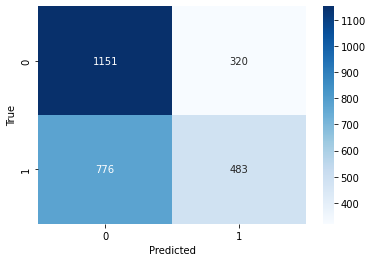

  
#################
ROC AUC
  


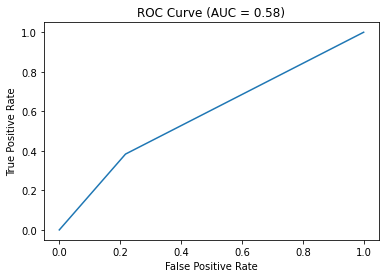

############### Sem balanceamento 3 classes ###############
tuning...
  
#################
Validar o modelo
  
training set score: 0.605642
test set score: 0.598535
  
#################
Métrica geral
  
Accuracy: 59.85%
Precision: 59.94%
Recall: 58.30%
F1-score: 57.30%
  
#################
Classification Report
  
              precision    recall  f1-score   support

           0       0.60      0.78      0.68      1471
           1       0.60      0.38      0.47      1259

    accuracy                           0.60      2730
   macro avg       0.60      0.58      0.57      2730
weighted avg       0.60      0.60      0.58      2730

  
#################
Matriz de confusão
  


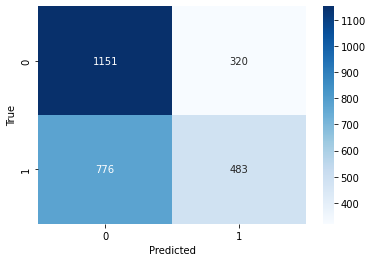

  
#################
ROC AUC
  


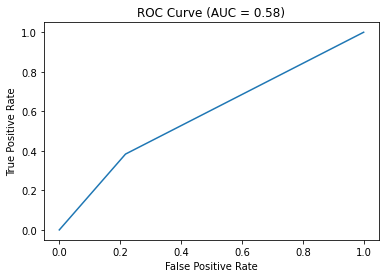

############### Sem balanceamento 3 classes + feature selector ###############
  
#################
Validar o modelo
  
training set score: 0.605642
test set score: 0.471062
  
#################
Métrica geral
  
Accuracy: 47.11%
Precision: 40.80%
Recall: 44.58%
F1-score: 39.21%
  
#################
Classification Report
  
              precision    recall  f1-score   support

           0       0.51      0.77      0.61      1471
           1       0.31      0.12      0.17      1259

    accuracy                           0.47      2730
   macro avg       0.41      0.45      0.39      2730
weighted avg       0.42      0.47      0.41      2730

  
#################
Matriz de confusão
  


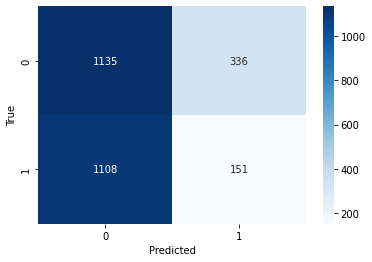

  
#################
ROC AUC
  


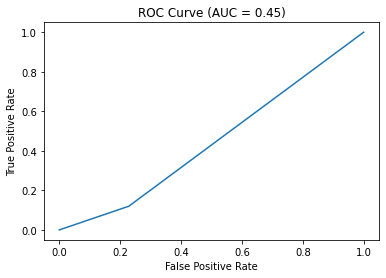

############### Sem balanceamento 3 classes + feature selector ###############
  
#################
Validar o modelo
  
training set score: 0.605642
test set score: 0.471062
  
#################
Métrica geral
  
Accuracy: 47.11%
Precision: 40.80%
Recall: 44.58%
F1-score: 39.21%
  
#################
Classification Report
  
              precision    recall  f1-score   support

           0       0.51      0.77      0.61      1471
           1       0.31      0.12      0.17      1259

    accuracy                           0.47      2730
   macro avg       0.41      0.45      0.39      2730
weighted avg       0.42      0.47      0.41      2730

  
#################
Matriz de confusão
  


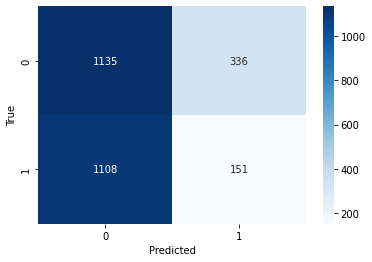

  
#################
ROC AUC
  


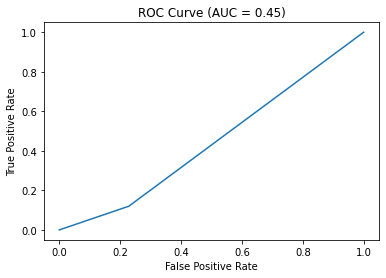

In [66]:
logistic_regression_versao('Sem balanceamento 2 classes',X_train, y_train, X_test,y_test,in_tune=False)
logistic_regression_versao('Sem balanceamento 2 classes',X_train, y_train, X_test,y_test,in_tune=True)
logistic_regression_versao('Sem balanceamento 2 classes + feature selector',X_train_new, y_train, X_test_new,y_test,in_tune=False)
logistic_regression_versao('Sem balanceamento 2 classes + feature selector',X_train_new, y_train, X_test_new,y_test,in_tune=False)
#logistic_regression_versao('Com balanceamento  3 classes',X_train_re, y_train_re, X_test_re,y_test_re)

Precisão: A precisão para cada classe mede a proporção de verdadeiros positivos entre os exemplos que o modelo previu pertencer a essa classe. Uma pontuação de precisão alta para uma determinada classe indica que o modelo identificou corretamente uma grande proporção dos exemplos que realmente pertencem a essa classe, enquanto minimiza o número de falsos positivos. Em outras palavras, nos diz o quão confiáveis são as previsões positivas do modelo para aquela classe em particular. Uma pontuação de precisão baixa para uma determinada classe indica que o modelo está fazendo muitas previsões falsos positivos para aquela classe, o que pode levar a consequências negativas ou custos mais elevados. Por exemplo, em uma tarefa de análise de sentimento multiclasse, uma pontuação de precisão alta para a classe negativa indicaria que o modelo está identificando com precisão o sentimento negativo, o que pode ser importante para o serviço ao cliente ou a melhoria do produto.

Recall: O recall para cada classe mede a proporção de verdadeiros positivos entre todos os exemplos que realmente pertencem a essa classe. Uma pontuação de recall alta para uma determinada classe indica que o modelo é capaz de identificar a maioria dos exemplos que realmente pertencem a essa classe, mesmo que também identifique alguns falsos positivos. Em outras palavras, nos diz o quão bom o modelo é em encontrar todos os casos positivos para aquela classe em particular. Uma pontuação de recall baixa para uma determinada classe indica que o modelo está perdendo muitos dos exemplos que realmente pertencem a essa classe, o que pode levar a oportunidades perdidas ou menor desempenho. Por exemplo, em uma tarefa de classificação de imagens multiclasse, uma pontuação de recall alta para a classe rara indicaria que o modelo é capaz de identificar a maioria dos exemplos daquela classe, o que pode ser importante para a segurança ou a proteção.

F1-score: O F1-score para cada classe é um equilíbrio entre precisão e recall para aquela classe em particular. Nos diz como o modelo é capaz de encontrar todos os casos positivos para aquela classe em particular, minimizando as previsões falsos positivos. Uma pontuação de F1 alta para uma determinada classe indica que o modelo é bom tanto em precisão quanto em recall para aquela classe, enquanto uma pontuação de F1 baixa indica que o modelo está faltando em uma ou ambas as métricas. Um negócio pode usar o F1-score para cada classe como uma métrica geral do desempenho do modelo, especialmente em situações em que tanto a precisão quanto o recall são importantes para aquela classe em particular. Por exemplo, em uma tarefa de classificação multiclasse para diagnóstico médico, um F1-score alto para a classe de doença rara indicaria que o modelo está identificando com precisão a maioria dos casos daquela doença, evitando alarmes falsos.